In [1]:
%matplotlib inline
import pandas as pd
from os.path import join
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import skbio
# from q2d2 import get_within_between_distances, filter_dm_and_map
from stats import mc_t_two_sample
from skbio.stats.distance import anosim, permanova
from skbio.stats.composition import ancom, multiplicative_replacement
import itertools

/home/johnchase/.conda/envs/da/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


##Define a couple of helper functions

In [2]:
def get_within_between_distances(map_df, dm, col):
    filtered_dm, filtered_map = filter_dm_and_map(dm, map_df)
    groups = []
    distances = []
    map_dict = filtered_map[col].to_dict()
    for id_1, id_2 in itertools.combinations(filtered_map.index.tolist(), 2):
        row = []
        if map_dict[id_1] == map_dict[id_2]:
            groups.append('Within')
        else:
            groups.append('Between')
        distances.append(filtered_dm[(id_1, id_2)])
    groups = zip(groups, distances)
    distances_df = pd.DataFrame(data=list(groups), columns=['Groups', 'Distance'])

    return distances_df
    
    
def filter_dm_and_map(dm, map_df):
    ids_to_exclude = set(dm.ids) - set(map_df.index.values)
    ids_to_keep = set(dm.ids) - ids_to_exclude
    filtered_dm = dm.filter(ids_to_keep)
    filtered_map = map_df.loc[ids_to_keep]

    return filtered_dm, filtered_map

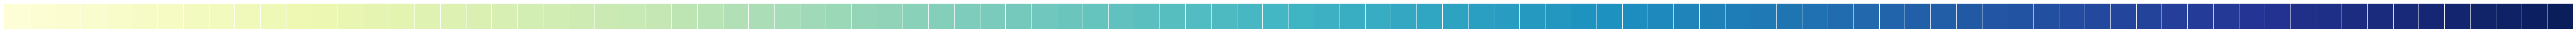

In [3]:
colors = sns.color_palette("YlGnBu", 100)
sns.palplot(colors)

Load mapping file and munge it
-----------------

In [4]:
home = '/home/office-microbe-files'
map_fp = join(home, 'master_map_150908.txt')

In [5]:
sample_md = pd.read_csv(map_fp, sep='\t', index_col=0, dtype=str)
sample_md = sample_md[sample_md['16SITS'] == 'ITS']
sample_md = sample_md[sample_md['OfficeSample'] == 'yes']

In [6]:
replicate_ids = '''F2F.2.Ce.021
F2F.2.Ce.022
F2F.3.Ce.021
F2F.3.Ce.022
F2W.2.Ca.021
F2W.2.Ca.022
F2W.2.Ce.021
F2W.2.Ce.022
F3W.2.Ce.021
F3W.2.Ce.022
F1F.3.Ca.021
F1F.3.Ca.022
F1C.3.Ca.021
F1C.3.Ca.022
F1W.2.Ce.021
F1W.2.Ce.022
F1W.3.Dr.021
F1W.3.Dr.022
F1C.3.Dr.021
F1C.3.Dr.022
F2W.3.Dr.059
F3F.2.Ce.078'''.split('\n')

In [7]:
reps = sample_md[sample_md['Description'].isin(replicate_ids)]
reps = reps.drop(reps.drop_duplicates('Description').index).index
sample_md.drop(reps, inplace=True)

Load alpha diversity
----------------------

In [8]:
alpha_div_fp = '/home/johnchase/office-project/office-microbes/notebooks/UNITE-analysis/core_div/core_div_open/arare_max999/alpha_div_collated/observed_species.txt'
alpha_div = pd.read_csv(alpha_div_fp, sep='\t', index_col=0)
alpha_div = alpha_div.T.drop(['sequences per sample', 'iteration'])
alpha_cols = [e for e in alpha_div.columns if '990' in e]
alpha_div = alpha_div[alpha_cols]
sample_md = pd.concat([sample_md, alpha_div], axis=1, join='inner')
sample_md['MeanAlpha'] = sample_md[alpha_cols].mean(axis=1)
sample_md['MedianAlpha'] = sample_md[alpha_cols].median(axis=1)
alpha_div = pd.read_csv(alpha_div_fp, sep='\t', index_col=0)
alpha_div = alpha_div.T.drop(['sequences per sample', 'iteration'])
alpha_cols = [e for e in alpha_div.columns if '990' in e]
alpha_div = alpha_div[alpha_cols]

add alpha diversity to map
-------------

In [9]:
sample_md = pd.concat([sample_md, alpha_div], axis=1, join='inner')
sample_md['MeanAlpha'] = sample_md[alpha_cols].mean(axis=1)

Filter the samples so that only corrosponding row 2, 3 samples are included
-----------------------------------------------------------

In [10]:
sample_md['NoRow'] = sample_md['Description'].apply(lambda x: x[:3] + x[5:])
row_df = sample_md[sample_md.duplicated('NoRow', keep=False)].copy()

In [11]:
row_df['SampleType'] = 'All Row 2/3 Pairs (n={0})'.format(int(len(row_df)/2))
plot_row_df = row_df[['Row', 'MeanAlpha', 'SampleType']]


sample_md_wall = row_df[row_df['PlateLocation'] != 'floor'].copy()
sample_md_wall['SampleType'] = 'Wall and Ceiling Pairs (n={0})'.format(int(len(sample_md_wall)/2))
plot_sample_md_wall = sample_md_wall[['Row', 'MeanAlpha', 'SampleType']]

sample_md_floor = row_df[row_df['PlateLocation'] == 'floor'].copy()
sample_md_floor['SampleType'] = 'Floor Pairs (n={0})'.format(int(len(sample_md_floor)/2))
plot_sample_md_floor = sample_md_floor[['Row', 'MeanAlpha', 'SampleType']]

plot_df = pd.concat([plot_row_df, plot_sample_md_wall, plot_sample_md_floor])

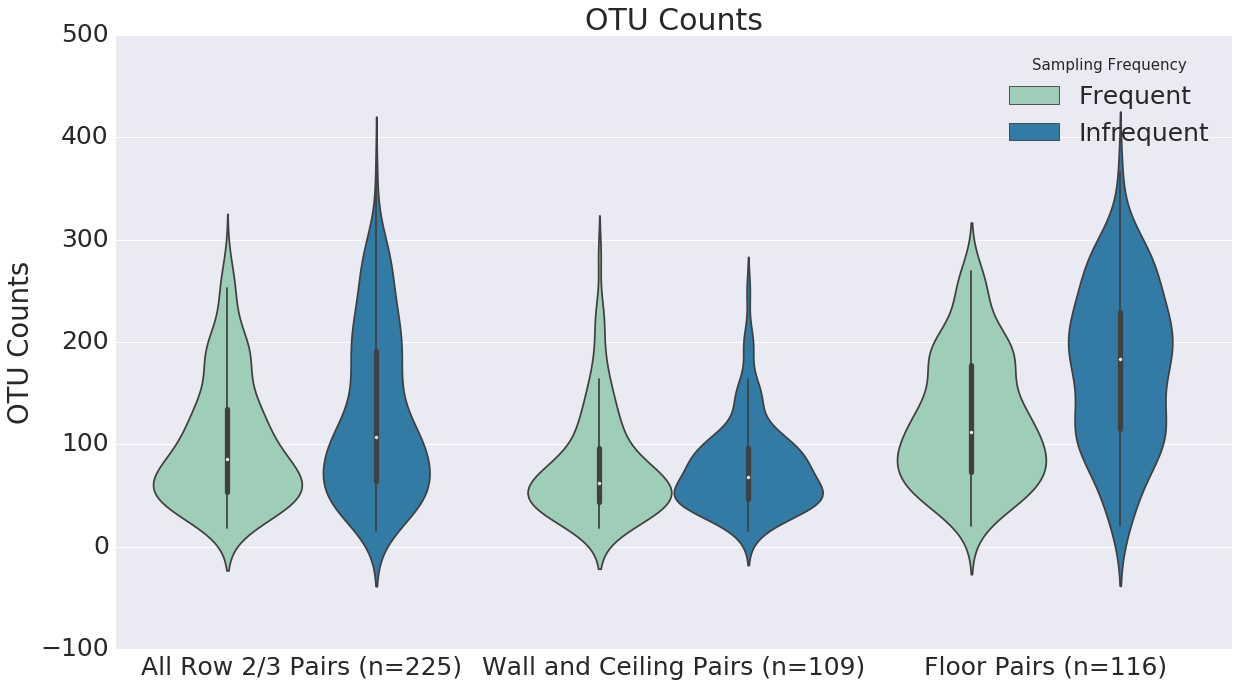

In [12]:
with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=2.5))):
    plt.figure(figsize=(20, 11))

    ax = sns.violinplot(x='SampleType', y='MeanAlpha', data=plot_df, hue='Row', hue_order=['3', '2'], 
                        palette="YlGnBu")
    ax.set_xlabel('')
    handles, labels = ax.get_legend_handles_labels()
    ax.set_ylabel('OTU Counts')
    ax.set_title('OTU Counts')
    ax.legend(handles, ['Frequent', 'Infrequent'], title='Sampling Frequency')
    ax.get_legend().get_title().set_fontsize('15')
    plt.savefig('figure-3-its-A.svg', dpi=300)

In [13]:
row_2_values = list(row_df[(row_df['Row'] == '2')]['MeanAlpha'])
row_3_values = list(row_df[(row_df['Row'] == '3')]['MeanAlpha'])
obs_t, param_p_val, perm_t_stats, nonparam_p_val = mc_t_two_sample(row_2_values, row_3_values)
obs_t, param_p_val
print((obs_t, param_p_val), "row 2 mean: {0}, row 1 mean: {1}".format(np.mean(row_2_values),np.mean(row_3_values)))

(4.178368737487422, 3.5310986970626956e-05) row 2 mean: 129.0457013574661, row 1 mean: 101.25458515283844


In [14]:
row_2_values = list(sample_md_wall[(sample_md_wall['Row'] == '2')]['MeanAlpha'])
row_3_values = list(sample_md_wall[(sample_md_wall['Row'] == '3')]['MeanAlpha'])
obs_t, param_p_val, perm_t_stats, nonparam_p_val = mc_t_two_sample(row_2_values, row_3_values)
print((obs_t, param_p_val), "row 2 mean: {0}, row 1 mean: {1}".format(np.mean(row_2_values),np.mean(row_3_values)))

(-0.07797815663743306, 0.93791761535347895) row 2 mean: 77.58396226415094, row 1 mean: 78.07857142857142


In [15]:
row_2_values = list(sample_md_floor[(sample_md_floor['Row'] == '2')]['MeanAlpha'])
row_3_values = list(sample_md_floor[(sample_md_floor['Row'] == '3')]['MeanAlpha'])
obs_t, param_p_val, perm_t_stats, nonparam_p_val = mc_t_two_sample(row_2_values, row_3_values)
print((obs_t, param_p_val), "row 2 mean: {0}, row 1 mean: {1}".format(np.mean(row_2_values),np.mean(row_3_values)))

(5.8449136803810715, 1.7233641180780523e-08) row 2 mean: 176.48000000000002, row 1 mean: 123.44017094017092


#Beta Diversity!


Create beta diversity boxplots of within and bewteen distances for row. It may not make a lot of sense doing this for all samples as the location and or city affect may drown out the row affect

Load the distance matrix
----------------------

In [16]:
dm = skbio.DistanceMatrix.read(join(home, '/home/johnchase/office-project/office-microbes/notebooks/UNITE-analysis/core_div/core_div_open/bdiv_even999/binary_jaccard_dm.txt'))

Run permanova and recored within between values on various categories
----------------------

All of these will be based on the row 2, 3 paired samples, though they may be filtered to avoind confounding variables

###Row distances

In [17]:
filt_map = row_df[(row_df['City'] == 'flagstaff') & (row_df['Run'] == '2')]
filt_dm, filt_map = filter_dm_and_map(dm, filt_map)

row_dists = get_within_between_distances(filt_map, filt_dm, 'Row')
row_dists['Category'] = 'Row (n=198)'

permanova(filt_dm, filt_map, column='Row', permutations=999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      47
number of groups                  2
test statistic               1.0128
p-value                       0.275
number of permutations          999
Name: PERMANOVA results, dtype: object

###Plate location

We can use the same samples for this as the previous test

In [18]:
plate_dists = get_within_between_distances(filt_map, filt_dm, 'PlateLocation')
plate_dists['Category'] = 'Plate Location (n=198)'

permanova(filt_dm, filt_map, column='PlateLocation', permutations=999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      47
number of groups                  3
test statistic              1.11431
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

###Run

In [19]:
filt_map = row_df[(row_df['City'] == 'flagstaff')]
filt_dm, filt_map = filter_dm_and_map(dm, filt_map)
run_dists = get_within_between_distances(filt_map, filt_dm, 'Run')
run_dists['Category'] = 'Run (n=357)'
permanova(filt_dm, filt_map, column='Run', permutations=999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     228
number of groups                  3
test statistic              1.41295
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

###Material

In [20]:
filt_map = row_df[(row_df['City'] == 'flagstaff') & (row_df['Run'] == '2')]
filt_dm, filt_map = filter_dm_and_map(dm, filt_map)

material_dists = get_within_between_distances(filt_map, filt_dm, 'Material')
material_dists['Category'] = 'Material (n=198)'

permanova(filt_dm, filt_map, column='Material', permutations=999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      47
number of groups                  3
test statistic              1.01402
p-value                       0.194
number of permutations          999
Name: PERMANOVA results, dtype: object

In [21]:
all_dists = material_dists.append(row_dists).append(plate_dists).append(run_dists)

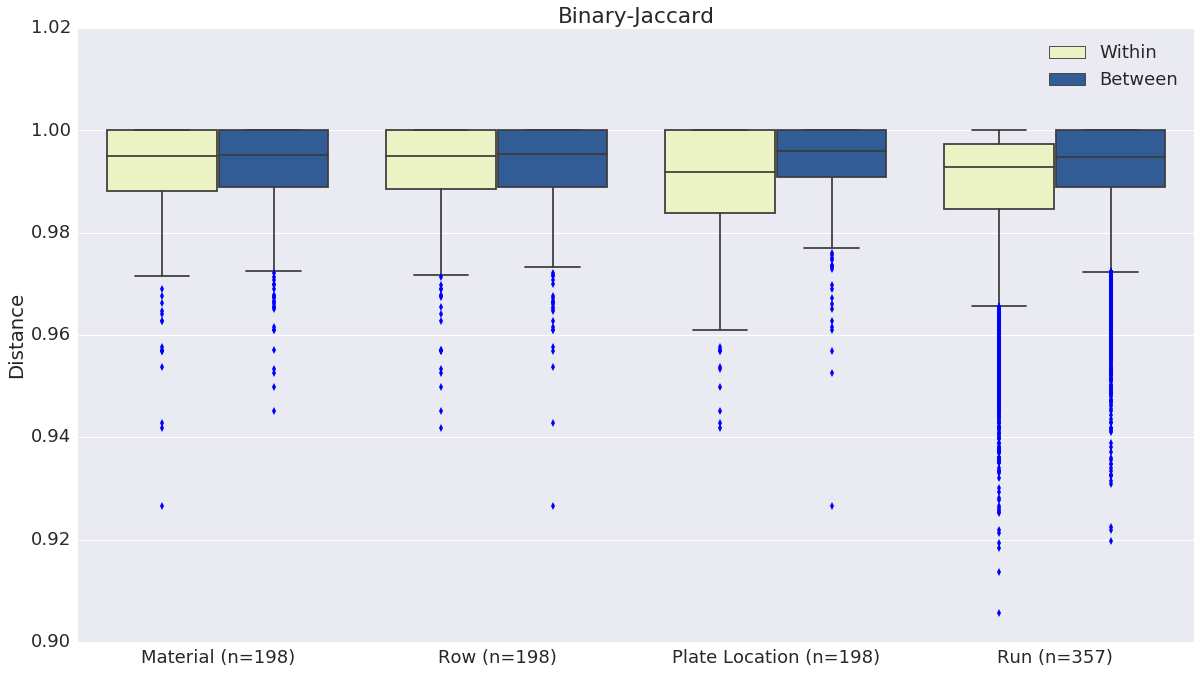

In [22]:
with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=1.8))):
    plt.figure(figsize=(20,11))
    ax = sns.boxplot(x="Category", y="Distance", hue="Groups", hue_order=['Within', 'Between'], data=all_dists, palette=sns.color_palette(['#f1fabb', '#2259a6']))
    ax.set_ylim([0.9, 1.02])
    ax.set_xlabel('')
    ax.set_title('Binary-Jaccard')
    plt.legend(loc='upper right')
    
    plt.savefig('figure-3-its-B.svg', dpi=300)
    

In [23]:
dm = skbio.DistanceMatrix.read(join(home, '/home/johnchase/office-project/office-microbes/notebooks/UNITE-analysis/core_div/core_div_open/bdiv_even999/bray_curtis_dm.txt'))


##Row Distances

In [24]:
filt_map = row_df[(row_df['City'] == 'flagstaff') & (row_df['Run'] == '2')]
filt_dm, filt_map = filter_dm_and_map(dm, filt_map)

row_dists = get_within_between_distances(filt_map, filt_dm, 'Row')
row_dists['Category'] = 'Row (n=198)'

permanova(filt_dm, filt_map, column='Row', permutations=999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      47
number of groups                  2
test statistic              1.06308
p-value                         0.1
number of permutations          999
Name: PERMANOVA results, dtype: object

##Plate Location

In [25]:
plate_dists = get_within_between_distances(filt_map, filt_dm, 'PlateLocation')
plate_dists['Category'] = 'Plate Location (n=198)'

permanova(filt_dm, filt_map, column='PlateLocation', permutations=999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      47
number of groups                  3
test statistic               1.0999
p-value                       0.009
number of permutations          999
Name: PERMANOVA results, dtype: object

##Run

In [26]:
filt_map = row_df[(row_df['City'] == 'flagstaff')]
filt_dm, filt_map = filter_dm_and_map(dm, filt_map)
run_dists = get_within_between_distances(filt_map, filt_dm, 'Run')
run_dists['Category'] = 'Run (n=357)'
permanova(filt_dm, filt_map, column='Run', permutations=999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     228
number of groups                  3
test statistic              2.01541
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

##Material

In [27]:
filt_map = row_df[(row_df['City'] == 'flagstaff') & (row_df['Run'] == '2')]
filt_dm, filt_map = filter_dm_and_map(dm, filt_map)

material_dists = get_within_between_distances(filt_map, filt_dm, 'Material')
material_dists['Category'] = 'Material (n=198)'

permanova(filt_dm, filt_map, column='Material', permutations=999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      47
number of groups                  3
test statistic              1.01254
p-value                       0.327
number of permutations          999
Name: PERMANOVA results, dtype: object

In [28]:
all_dists = material_dists.append(row_dists).append(plate_dists).append(run_dists)

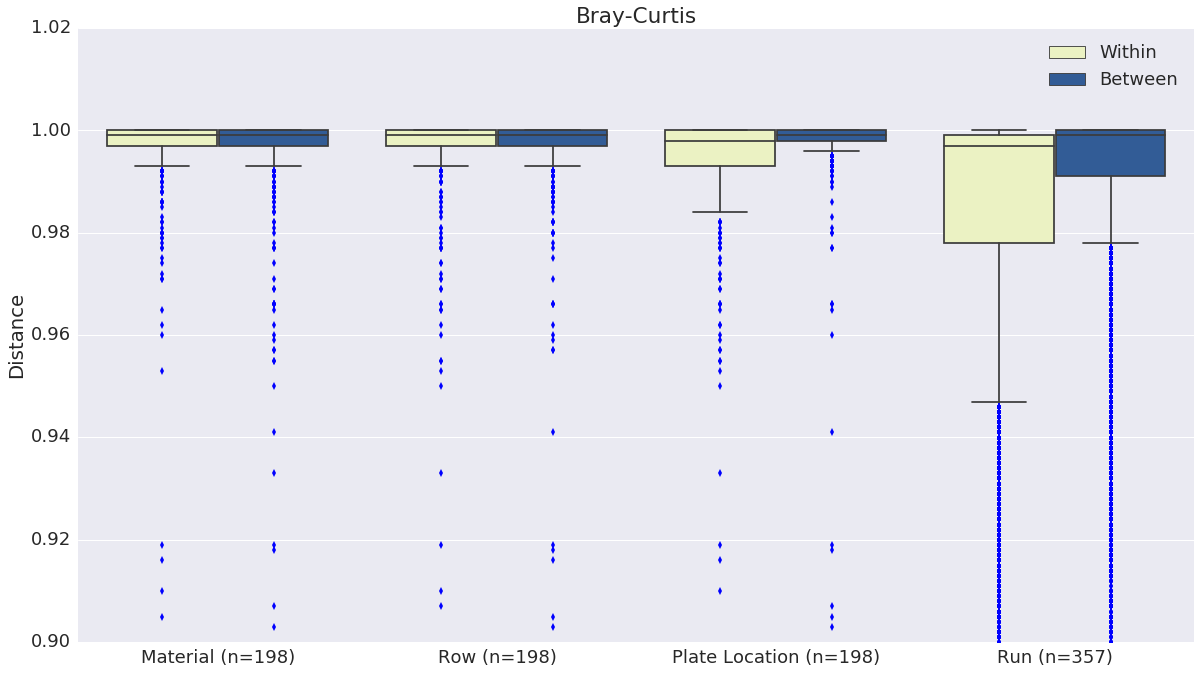

In [29]:
with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=1.8))):
    plt.figure(figsize=(20,11))
    ax = sns.boxplot(x="Category", y="Distance", hue="Groups", hue_order=['Within', 'Between'], data=all_dists, palette=sns.color_palette(['#f1fabb', '#2259a6']))
    ax.set_ylim([0.9, 1.02])
    ax.set_xlabel('')
    ax.set_title('Bray-Curtis')
    plt.legend(loc='upper right')
    
    plt.savefig('figure-3-its-C.svg', dpi=300)

ANCOM
-----

In [30]:
table_fp = join(home, 'core_div_out/table_even1000.txt')
table = pd.read_csv(table_fp, sep='\t', skiprows=1, index_col=0).T
table.index = table.index.astype(str)

/home/johnchase/.conda/envs/da/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [31]:
table_ancom = table.loc[:, table[:3].sum(axis=0) > 0]

In [32]:
table_ancom = pd.DataFrame(multiplicative_replacement(table_ancom), index=table_ancom.index, columns=table_ancom.columns)
table_ancom.dropna(axis=0, inplace=True)
intersect_ids = set(row_md.index).intersection(set(table_ancom.index))
row_md_ancom = row_md.loc[intersect_ids, ]
table_ancom = table_ancom.loc[intersect_ids, ]

NameError: name 'row_md' is not defined

In [ ]:
%time
results = ancom(table_ancom, row_md_ancom['Row'])

In [ ]:
sigs = results[results['reject'] == True]

In [ ]:
tax_fp = '/home/office-microbe-files/pick_otus_out_97/uclust_assigned_taxonomy/rep_set_tax_assignments.txt'
taxa_map = pd.read_csv(tax_fp, sep='\t', index_col=0, names=['Taxa', 'none', 'none'])
taxa_map.drop('none', axis=1, inplace=True)
taxa_map.index = taxa_map.index.astype(str)

In [ ]:
taxa_map.loc[sigs.sort_values('W').index.astype(str)]

In [ ]:
pd.options.display.max_colwidth = 200

In [ ]:
sigs

In [ ]:
np.mean(w_dm.data)

In [ ]:
np.median(w_dm.data)

In [ ]:
w_dm = skbio.DistanceMatrix.read(join(home, '/home/johnchase/office-project/office-microbes/notebooks/UNITE-analysis/core_div/core_div_closed/bdiv_even1000/bray_curtis_dm.txt'))


In [ ]:
np.mean(w_dm.data)

In [ ]:
np.median(w_dm.data)

In [1]:
4980239/22783729

0.21858752796787567

In [ ]:
foo